# GAN for Fashion MNIST 

This notebook consists of an example code for building a basic GAN using CNN based generator and discrimator networks. It is mostly inspired by a tutorial available on askpython website - https://www.askpython.com/python-modules/training-gan-in-pytorch. The hyperparameters or the complexity of the architecture were not optimized for the given dataset -  Fashion MNIST. Also, the number of epochs was not optimal either. With the only purpose of understanding, this GAN was built using PyTorch library and uses batch normalization, convolutions, transposed convolutions, and two types of activations - tanh, LeakyReLU.

Binary cross-entropy with logits is used to build losses for discriminator (D) and generator (G). G-loss is given by fraction of successful fake detection by D for randomly generated signals by G. D-loss has two parts which are averaged - loss from successful classification of fake signals generated by G and loss from successful classification of real signals given by the dataset.


In [367]:
import numpy as np
import matplotlib.pyplot as plt

In [399]:
import torch
from torch.nn import Module, Sequential, Linear, Conv2d, ConvTranspose2d, MaxPool2d, LeakyReLU, Dropout, BCEWithLogitsLoss, BatchNorm2d, Tanh
from torchvision.transforms import ToTensor
import torchvision.datasets as ds
from torch.utils.data import DataLoader
training_data = ds.FashionMNIST(root="./data",train=True,download=True,transform=None)
testing_data = ds.FashionMNIST(root="./data",train=False,download=True,transform=None)

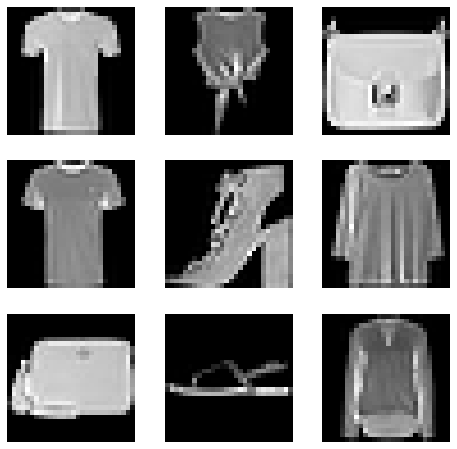

In [400]:
# visualizing the dataset
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
#     plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

training_data = ds.FashionMNIST(root="./data",train=True,download=True,transform=ToTensor())
testing_data = ds.FashionMNIST(root="./data",train=False,download=True,transform=ToTensor())

In [391]:
class generator(Module):
    '''
        Generator network architecture
        - takes vector of length (latent_dim) and returns tensor of shape (im_channel,l,b)
    '''
    def __init__(self, latent_dim, im_channel, hidden_dim = 64):
        super().__init__()

        self.latent_dim = latent_dim
        
        # raise the latent_dim to enough size for reshaping into 128x7x7
        self.A1 = LeakyReLU(negative_slope=0.2)
        self.A2 = Tanh()

        # transposed convolution with 2 kernel size and 2 stride (upsampling happens)
        self.CT1 = ConvTranspose2d(latent_dim,  hidden_dim*4,3,2,padding=0)
        self.CT2 = ConvTranspose2d(hidden_dim*4,hidden_dim*2,4,1,padding=0)
        self.CT3 = ConvTranspose2d(hidden_dim*2,hidden_dim  ,3,2,padding=0)
        self.CT4 = ConvTranspose2d(hidden_dim,  im_channel  ,4,2,padding=0)

        self.BN1 = BatchNorm2d(4*hidden_dim)
        self.BN2 = BatchNorm2d(2*hidden_dim)
        self.BN3 = BatchNorm2d(  hidden_dim)        
        
    def forward(self, noise):
    
        tmp = noise.view(len(noise),self.latent_dim,1,1)
        tmp = self.CT1(tmp)
        tmp = self.BN1(tmp)
        tmp = self.A1(tmp)
        
        tmp = self.CT2(tmp)
        tmp = self.BN2(tmp)
        tmp = self.A1(tmp)
        
        tmp = self.CT3(tmp)
        tmp = self.BN3(tmp)
        tmp = self.A1(tmp)
        
        tmp = self.CT4(tmp)
        tmp = self.A2(tmp)
        
        return tmp
        
        
class discriminator(Module):
    '''
        Discriminator network architecture
        - takes (N,im_channels,l,b) tensor and returns (N) labels for fake/real, i.e., 0/1
    '''
    def __init__(self,im_channels,hidden_dim=16):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        self.C1  = Conv2d(im_channels,hidden_dim,4,2,padding=0)
        self.C2  = Conv2d(hidden_dim,hidden_dim*2,4,2,padding=0)
        self.C3  = Conv2d(hidden_dim*2,1,4,2,padding=0)
        self.BN1 = BatchNorm2d(hidden_dim)
        self.BN2 = BatchNorm2d(hidden_dim*2)
         
        self.A = LeakyReLU(negative_slope=0.2)
    
    def forward(self,tensor):
        # performing convolution and downsampling followed by activation
        tmp = self.C1(tensor)
        tmp = self.BN1(tmp)
        tmp = self.A(tmp)
        
        tmp = self.C2(tmp)
        tmp = self.BN2(tmp)
        tmp = self.A(tmp)
        
        tmp = self.C3(tmp)
        
        return tmp.view(len(tmp),-1)


def generator_loss(gen, disc, batch_size, latent_dim):
    '''
        - Loss for generator is when discriminator classifies its output as fake!
    '''
    # using BCE with Logits loss function to collect binary errors and average it
    Loss = BCEWithLogitsLoss()
    
    noise = torch.randn(batch_size,latent_dim)
    
    # generating fakes 
    gen_data = gen(noise)
    
    # evaluating fakes
    disc_gen_data = disc(gen_data)
    
    # comparing evaluation with the event when all the discriminated data was found to be real 
    # (Discriminator failure -or- Generator success)
    gen_loss = Loss(disc_gen_data, torch.ones_like(disc_gen_data))

    return gen_loss


def discriminator_loss(gen, disc, real_data, batch_size, latent_dim):
    '''
        - Loss is computed against discrimination of real (from training data) and fake (from generator) images
        - training data is incorporated only in the discriminator loss
    '''
    # using BCE with Logits loss function to collect binary errors and average it
    Loss = BCEWithLogitsLoss()
    
    noise = torch.randn(batch_size,latent_dim)
    gen_data = gen(noise)
    disc_gen_data = disc(gen_data)
    disc_real_data = disc(real_data)
    
    
    # loss contribution from false positives in generated data
    loss1 = Loss(disc_gen_data, torch.zeros_like(disc_gen_data))
    
    # loss contribution from false negatives in real data
    loss2 = Loss(disc_real_data, torch.ones_like(disc_real_data))
    
    disc_loss = (loss1 + loss2)/2
    
    return disc_loss




In [392]:
im_channels = 3
latent_dim = 64
batch_size = 10

gen = generator(latent_dim,im_channels)
noise = torch.randn(batch_size,latent_dim)
print(gen)
print("Generated output has size = ", gen(noise).shape)

print("\n\n")

dis = discriminator(im_channels)
gen_out = gen(noise)
print(dis)
print("Result of discriminator has size = ", dis(gen_out).shape)

generator(
  (A1): LeakyReLU(negative_slope=0.2)
  (A2): Tanh()
  (CT1): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
  (CT2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
  (CT3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (CT4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2))
  (BN1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Generated output has size =  torch.Size([10, 3, 28, 28])



discriminator(
  (C1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2))
  (C2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (C3): Conv2d(32, 1, kernel_size=(4, 4), stride=(2, 2))
  (BN1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

In [393]:
batch_size = 128
data = DataLoader(training_data, batch_size=batch_size, shuffle=True)

latent_dim = 100
channels = 1
lr = 3e-4

# device = "cpu"

# loading parameters to the device
gen = generator(latent_dim,channels)
disc = discriminator(channels)

# configuring the optimizer for both networks
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr,betas=(0.5,0.999))
disc_opt = torch.optim.Adam(disc.parameters(),lr=lr,betas=(0.5,0.999))

# initializing the weights of convolution layers 
def weights_init(m):
    if isinstance(m,Conv2d) or isinstance(m,ConvTranspose2d):
        torch.nn.init.normal_(m.weight,0.0,0.02)
    if isinstance(m,BatchNorm2d):
        torch.nn.init.normal_(m.weight,0.0,0.02)
        torch.nn.init.constant_(m.bias,0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)


In [394]:
num_epoch = 100
display_step = 100
itr = 0

glosslist = []
dlosslist = []

for epoch in range(num_epoch):
    for im, _ in data:
        
        real_data = im
        disc_opt.zero_grad()
        DLoss = discriminator_loss(gen,disc,real_data,batch_size,latent_dim)
        DLoss.backward()
        disc_opt.step()
        
        gen_opt.zero_grad()
        GLoss = generator_loss(gen,disc,batch_size,latent_dim)
        GLoss.backward()
        gen_opt.step()
        
        dlosslist.append(DLoss.item())
        glosslist.append(GLoss.item())
        
        itr += 1
    print("Epoch: ",epoch+1, "\n\tGenerator Loss: ", GLoss.item(),"\n\tDiscriminator Loss: ", DLoss.item())
    
torch.save(gen,"./saved_models/gen.pt")
torch.save(disc,"./saved_models/disc.pt")

Epoch:  1 
	Generator Loss:  0.7166436910629272 
	Discriminator Loss:  0.7043907642364502
Epoch:  2 
	Generator Loss:  0.7104624509811401 
	Discriminator Loss:  0.6951481103897095
Epoch:  3 
	Generator Loss:  0.6983046531677246 
	Discriminator Loss:  0.6757608652114868
Epoch:  4 
	Generator Loss:  0.6836479306221008 
	Discriminator Loss:  0.6880092620849609
Epoch:  5 
	Generator Loss:  0.7040520906448364 
	Discriminator Loss:  0.686465859413147
Epoch:  6 
	Generator Loss:  0.7226578593254089 
	Discriminator Loss:  0.6825172305107117
Epoch:  7 
	Generator Loss:  0.7879537343978882 
	Discriminator Loss:  0.6772923469543457
Epoch:  8 
	Generator Loss:  0.6834108233451843 
	Discriminator Loss:  0.6851580142974854
Epoch:  9 
	Generator Loss:  0.6775954961776733 
	Discriminator Loss:  0.6855514645576477
Epoch:  10 
	Generator Loss:  0.6911273002624512 
	Discriminator Loss:  0.6983276605606079
Epoch:  11 
	Generator Loss:  0.7004606127738953 
	Discriminator Loss:  0.6950875520706177
Epoch:  1

Epoch:  92 
	Generator Loss:  0.6902750134468079 
	Discriminator Loss:  0.693203330039978
Epoch:  93 
	Generator Loss:  0.6954647302627563 
	Discriminator Loss:  0.6933760643005371
Epoch:  94 
	Generator Loss:  0.6907945871353149 
	Discriminator Loss:  0.6931444406509399
Epoch:  95 
	Generator Loss:  0.6918667554855347 
	Discriminator Loss:  0.6931058168411255
Epoch:  96 
	Generator Loss:  0.691469669342041 
	Discriminator Loss:  0.6934135556221008
Epoch:  97 
	Generator Loss:  0.6950497031211853 
	Discriminator Loss:  0.6931628584861755
Epoch:  98 
	Generator Loss:  0.6939820051193237 
	Discriminator Loss:  0.693425178527832
Epoch:  99 
	Generator Loss:  0.6922761797904968 
	Discriminator Loss:  0.6930989027023315
Epoch:  100 
	Generator Loss:  0.6946537494659424 
	Discriminator Loss:  0.6930326819419861


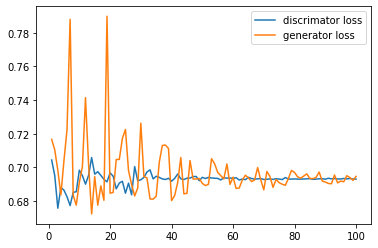

In [416]:
plt.figure()
# losslist contains loss from every batch for every epoch
plt.plot(range(1,101),dlosslist[469-1::469], label="discrimator loss")
plt.plot(range(1,101),glosslist[469-1::469], label="generator loss")
plt.legend()
plt.show()
plt.close()

(10, 28, 28)


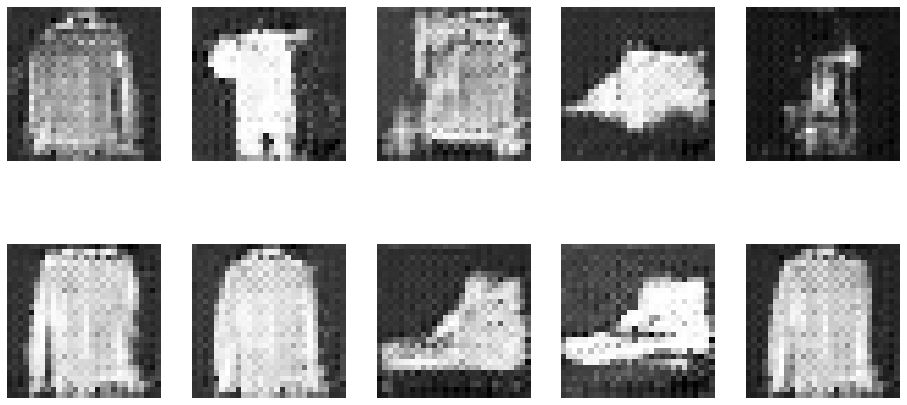

In [421]:
noise = torch.randn(10,latent_dim)
gen = torch.load("./saved_models/gen.pt")
gen_images = gen(noise).squeeze().detach().numpy()
print(gen_images.shape)

# plotting
figure = plt.figure(figsize=(16, 8))
cols, rows = 5, 2
for i in range(1, cols * rows +1):
    img = gen_images[i-1]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()
    